## Step 1: Data Splitting

In [ ]:
import pandas as pd

df = pd.read_csv('btc_processed.csv')

# Recreate Target identically to ann_model_pipeline using TARGET_HORIZON
TARGET_HORIZON = 7
close_col = 'close'
lookback = min(7, len(df) - TARGET_HORIZON)
df['MA_lookback'] = df[close_col].rolling(window=lookback, min_periods=1).mean()
current_uptrend = df[close_col] > df['MA_lookback']
future_rise = df[close_col].shift(-TARGET_HORIZON) > df[close_col]
df['Target'] = (current_uptrend & future_rise).astype(int)
df.drop('MA_lookback', axis=1, inplace=True)
# Drop last TARGET_HORIZON rows which don't have future data
df = df.iloc[:-TARGET_HORIZON].reset_index(drop=True)
print(f'Created Target for {TARGET_HORIZON}-day horizon; samples: {len(df)}')

In [2]:
# X_all = df.drop(columns=['date', 'Target'])
X_all = df[['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14']]
y_all = df['Target']

print (f"Feature matrix shape: {X_all.shape}")
print(X_all.head())
print (f"Target vector shape: {y_all.shape}")
print(y_all.head())

Feature matrix shape: (3377, 18)
         open        high         low       close      volume      rsi_7  \
0  226.440994  233.503998  216.309006  217.464005  23348200.0  35.643356   
1  216.867004  231.574005  212.014999  226.972000  29128500.0  43.755389   
2  226.490997  242.175003  222.658997  238.229004  30612100.0  52.095851   
3  237.453995  245.957001  224.483002  227.268005  40783700.0  44.585253   
4  227.511002  230.057999  221.113007  226.852997  26594300.0  44.303116   

      rsi_14      cci_7     cci_14      sma_50      ema_50     sma_100  \
0  39.545291 -98.071536 -51.796943  248.782547  242.606509  248.782547   
1  43.393165 -72.721346 -54.788070  248.100968  241.757327  248.100968   
2  47.642203  -7.891879 -12.669779  247.801817  241.568538  247.801817   
3  44.165876  20.037760 -32.194104  247.197882  240.814145  247.197882   
4  44.034862 -45.057541 -70.859064  246.616599  240.087492  246.616599   

      ema_100      macd   bollinger  TrueRange      atr_7     atr

- sliding windows (for time-series model)

In [3]:
import numpy as np

# defining window size (number of past days to consider for each prediction)
WINDOW_SIZE = 14

# Sequence creation (sliding windows)
def create_sequences(X, y, window_size):
    Xs = []
    ys = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)
# Create windows
X_seq, y_seq = create_sequences(X_all, y_all, WINDOW_SIZE)
print('Sequence shapes: X', X_seq.shape, 'y', y_seq.shape)


Sequence shapes: X (3363, 14, 18) y (3363,)


- data splitting

In [4]:
# Train-test split
TRAIN_RATIO = 0.8

# Chronological train-test split (no random shuffling)
n_samples = len(X_seq)
split_idx = int(n_samples * TRAIN_RATIO)
X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]
print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 2690 Test samples: 673


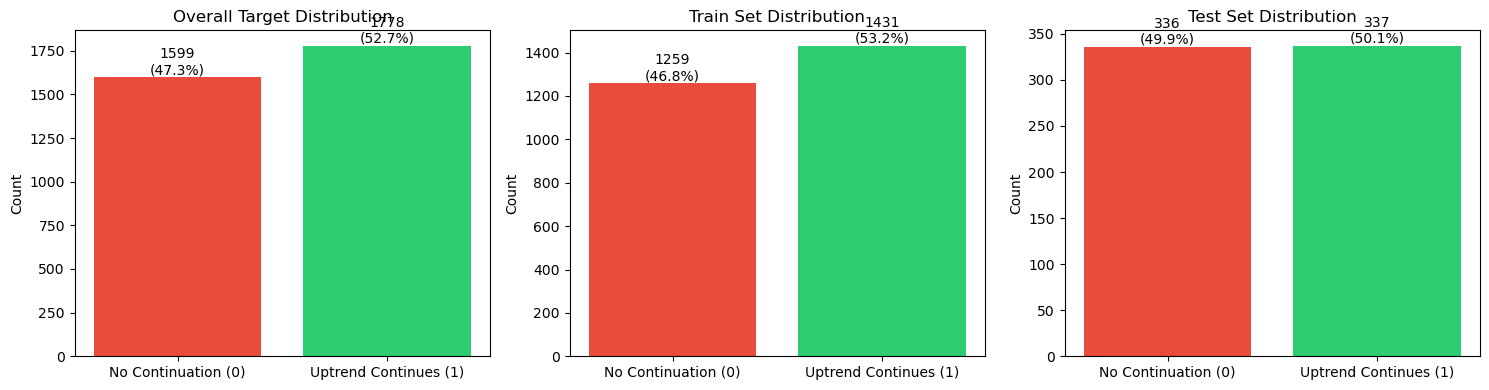


Class balance ratio (Uptrend Continues/No Continuation): 1.112


In [5]:
import matplotlib.pyplot as plt

# Plot class distribution to check for imbalance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall class distribution
unique, counts = np.unique(y_all, return_counts=True)
axes[0].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Target Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts)):
    axes[0].text(i, count, f'{count}\n({count/len(y_all)*100:.1f}%)', ha='center', va='bottom')

# Train set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[1].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Count')
axes[1].set_title('Train Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train)):
    axes[1].text(i, count, f'{count}\n({count/len(y_train)*100:.1f}%)', ha='center', va='bottom')

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test)):
    axes[2].text(i, count, f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f'\nClass balance ratio (Uptrend Continues/No Continuation): {counts[1]/counts[0]:.3f}')

- Normalization

In [6]:
from sklearn.preprocessing import RobustScaler

# Scaling: Use RobustScaler for better handling of outliers in crypto data
n_features = X_train.shape[2]
scaler = RobustScaler()  # More robust to outliers than MinMaxScaler
# reshape (num_train_samples * window_size, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)
scaler.fit(X_train_reshaped)
# transform train and test, preserve 3D shape for LSTM/GRU
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Create both versions: 3D for LSTM/GRU, flat for MLP
X_train_3d = X_train_scaled  # shape: (samples, window_size, features)
X_test_3d = X_test_scaled

print('✓ Using RobustScaler (better for crypto volatility)')
print('3D shape (for LSTM/GRU):', X_train_3d.shape, X_test_3d.shape)

✓ Using RobustScaler (better for crypto volatility)
3D shape (for LSTM/GRU): (2690, 14, 18) (673, 14, 18)


## Step 2: Model Training

- LSTM model

In [24]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, BatchNormalization
from tensorflow.keras.regularizers import l2


# defining model parameters
lr = 2e-4
dropout_rate = 0.3
USE_ATTENTION = True
USE_FOCAL_LOSS = True
WINDOW_SIZE = 14  # ensure this matches the window size used earlier

TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42

USE_ATTENTION = True  # Add attention mechanism to LSTM/GRU for better performance
USE_RESIDUAL = True  # Use residual connections for deeper networks
USE_FOCAL_LOSS = True  # Use focal loss to handle class imbalance better
USE_SMOTE = False  # Use SMOTE for synthetic minority oversampling (can help but may overfit)
OPTIMIZE_THRESHOLD = True  # Find optimal classification threshold instead of 0.5

# Focal loss parameters - more aggressive for severe imbalance
FOCAL_GAMMA = 3.0  # Increased from 2.0 - focuses more on hard examples
FOCAL_ALPHA = 0.75  # Increased from 0.25 - gives more weight to minority class

inputs = Input(shape=(WINDOW_SIZE, n_features))

# First Bi-LSTM layer
x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
x = LayerNormalization()(x)
x = Dropout(dropout_rate)(x)

# Second Bi-LSTM layer
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
x = LayerNormalization()(x)
x = Dropout(dropout_rate)(x)

# Attention mechanism (if enabled)
if USE_ATTENTION:
    # Self-attention layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attention_output])  # Residual connection
    x = LayerNormalization()(x)

# Final LSTM layer
x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
x = Dropout(dropout_rate)(x)

# Dense layers
x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate * 0.7)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(dropout_rate * 0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [26]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 14, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 14, 256)   │    150,528 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 256)   │        512 │ bidirectional_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 14, 256)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 14, 128)   │    164,352 │ dropout_12[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ bidirectional_5[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 14, 128)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 14, 128)   │     66,048 │ dropout_13[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 14, 128)   │          0 │ dropout_13[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 32)        │     20,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32)        │          0 │ lstm_8[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      2,112 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dropout_17[0][0]

 Total params: 407,041 (1.55 MB)

 Trainable params: 406,913 (1.55 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, BatchNormalization
from tensorflow.keras.regularizers import l2


# defining model parameters
lr = 2e-4
dropout_rate = 0.3
USE_ATTENTION = True
USE_FOCAL_LOSS = True
WINDOW_SIZE = 14  # ensure this matches the window size used earlier

TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42

USE_ATTENTION = True  # Add attention mechanism to LSTM/GRU for better performance
USE_RESIDUAL = True  # Use residual connections for deeper networks
USE_FOCAL_LOSS = True  # Use focal loss to handle class imbalance better
USE_SMOTE = False  # Use SMOTE for synthetic minority oversampling (can help but may overfit)
OPTIMIZE_THRESHOLD = True  # Find optimal classification threshold instead of 0.5

# Focal loss parameters - more aggressive for severe imbalance
FOCAL_GAMMA = 3.0  # Increased from 2.0 - focuses more on hard examples
FOCAL_ALPHA = 0.75  # Increased from 0.25 - gives more weight to minority class

inputs = Input(shape=(WINDOW_SIZE, n_features))

# First Bi-LSTM layer
x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
x = LayerNormalization()(x)
x = Dropout(dropout_rate)(x)

# Second Bi-LSTM layer
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
x = LayerNormalization()(x)
x = Dropout(dropout_rate)(x)

# Attention mechanism (if enabled)
if USE_ATTENTION:
    # Self-attention layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attention_output])  # Residual connection
    x = LayerNormalization()(x)

# Final LSTM layer
x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
x = Dropout(dropout_rate)(x)

# Dense layers
x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate * 0.7)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(dropout_rate * 0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

Class weights: {0: 1.068308181096108, 1: 0.9399021663172606}

🎯 Starting training with 2690 samples...
Validation split: 403 samples
Using focal loss: True
Batch size: 64 (optimized for better convergence)
Epoch 1/200

Epoch 1: val_auc improved from -inf to 0.57549, saving model to best_model_temp.h5


36/36 - 2s - 63ms/step - accuracy: 0.5267 - auc: 0.5718 - loss: 0.4092 - precision: 0.6379 - recall: 0.3235 - val_accuracy: 0.5718 - val_auc: 0.5755 - val_loss: 0.4079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 2/200

Epoch 2: val_auc did not improve from 0.57549
36/36 - 2s - 58ms/step - accuracy: 0.4904 - auc: 0.5510 - loss: 0.4126 - precision: 0.5847 - recall: 0.2552 - val_accuracy: 0.5718 - val_auc: 0.5687 - val_loss: 0.4041 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 3/200

Epoch 3: val_auc improved from 0.57549 to 0.58084, saving model to best_model_temp.h5


36/36 - 2s - 57ms/step - accuracy: 0.5105 - auc: 0.5656 - loss: 0.4099 - precision: 0.6192 - recall: 0.2870 - val_accuracy: 0.5718 - val_auc: 0.5808 - val_loss: 0.3995 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 4/200

Epoch 4: val_auc did not improve from 0.58084
36/36 - 2s - 60ms/step - accuracy: 0.5066 - auc: 0.5519 - loss: 0.4053 - precision: 0.6136 - recall: 0.2790 - val_accuracy: 0.5718 - val_auc: 0.5705 - val_loss: 0.4039 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 5/200

Epoch 5: val_auc did not improve from 0.58084
36/36 - 2s - 67ms/step - accuracy: 0.5057 - auc: 0.5625 - loss: 0.4045 - precision: 0.6119 - recall: 0.2782 - val_accuracy: 0.5718 - val_auc: 0.5576 - val_loss: 0.4097 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 6/200

Epoch 6: val_auc did not improve from 0.58084
36/36 - 2s - 60ms/step - accuracy: 0.5092 - auc: 0.5800 - loss: 0.4003 - pre

## Step 4: Model Inferencing

In [35]:
# Evaluate on test set
results = model.evaluate(X_test_3d, y_test, verbose=0)
print(f'  Loss: {results[0]:.4f}')
print(f'  Accuracy: {results[1]:.4f}')
print(f'  AUC: {results[2]:.4f}')
if len(results) > 3:
    print(f'  Precision: {results[3]:.4f}')
    print(f'  Recall: {results[4]:.4f}')
    f1 = 2 * (results[3] * results[4]) / (results[3] + results[4] + 1e-7)
    print(f'  F1-Score: {f1:.4f}')

  Loss: 0.4125
  Accuracy: 0.4993
  AUC: 0.5230
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


## Step 5: Model Evaluation

In [36]:
print(f'\n✅ Training completed!')
print(f'Total epochs: {len(history.history["loss"])}')
print(f'Best val_loss: {min(history.history["val_loss"]):.4f}')
print(f'Best val_auc: {max(history.history["val_auc"]):.4f}')
if 'val_precision' in history.history:
    print(f'Best val_precision: {max(history.history["val_precision"]):.4f}')
    print(f'Best val_recall: {max(history.history["val_recall"]):.4f}')


✅ Training completed!
Total epochs: 28
Best val_loss: 0.3853
Best val_auc: 0.5808
Best val_precision: 0.0000
Best val_recall: 0.0000


In [42]:
# Threshold tuning: choose a better decision threshold from validation
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix
import numpy as np

# Build a validation split from the tail of training data (chronological)
val_ratio = 0.15
val_size = int(len(X_train_3d) * val_ratio)
X_val = X_train_3d[-val_size:]
y_val = y_train[-val_size:]

# Predict probabilities on validation
val_probs = model.predict(X_val, verbose=0).ravel()

# Compute ROC and PR curves
fpr, tpr, roc_thr = roc_curve(y_val, val_probs)
precision, recall, pr_thr = precision_recall_curve(y_val, val_probs)

# Grid of candidate thresholds between PR thresholds (exclude last inf)
threshold_grid = pr_thr[:-1]

# Evaluate thresholds by multiple criteria
best = {
    'f1': -1, 'thr_f1': 0.5,
    'youden_j': -1, 'thr_j': 0.5,
    'bal_acc': -1, 'thr_bal': 0.5
}

for thr in threshold_grid:
    y_hat = (val_probs >= thr).astype(int)
    # Confusion
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()
    # Metrics
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    # Youden's J (maximize TPR - FPR)
    # find nearest ROC point
    j_scores = tpr - fpr
    j_idx = np.argmax(j_scores)
    youden_thr = roc_thr[j_idx]
    # Balanced accuracy
    acc = (tp/(tp+fn+1e-8) + tn/(tn+fp+1e-8)) / 2
    # Track best
    if f1 > best['f1']:
        best['f1'] = f1; best['thr_f1'] = thr
    if acc > best['bal_acc']:
        best['bal_acc'] = acc; best['thr_bal'] = thr
    best['youden_j'] = j_scores[j_idx]; best['thr_j'] = youden_thr

# Choose threshold prioritizing recall for positive class (to avoid missing uptrends)
threshold_to_use = best['thr_f1']
print(f"Selected threshold (max F1): {threshold_to_use:.4f}")

# Apply on test probabilities
if 'y_pred_prob_test' in globals():
    probs_test = y_pred_prob_test.ravel()
else:
    probs_test = model.predict(X_test_3d, verbose=0).ravel()

y_pred_optimal = (probs_test >= threshold_to_use).astype(int)

cm = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix @ tuned threshold:")
print(cm)

print("\nClassification Report @ tuned threshold:")
print(classification_report(y_test, y_pred_optimal, target_names=['Down/Equal (0)', 'Up (1)'], digits=4))

Selected threshold (max F1): 0.1255

Confusion Matrix @ tuned threshold:
[[  4 332]
 [  2 335]]

Classification Report @ tuned threshold:
                precision    recall  f1-score   support

Down/Equal (0)     0.6667    0.0119    0.0234       336
        Up (1)     0.5022    0.9941    0.6673       337

      accuracy                         0.5037       673
     macro avg     0.5845    0.5030    0.3454       673
  weighted avg     0.5843    0.5037    0.3458       673



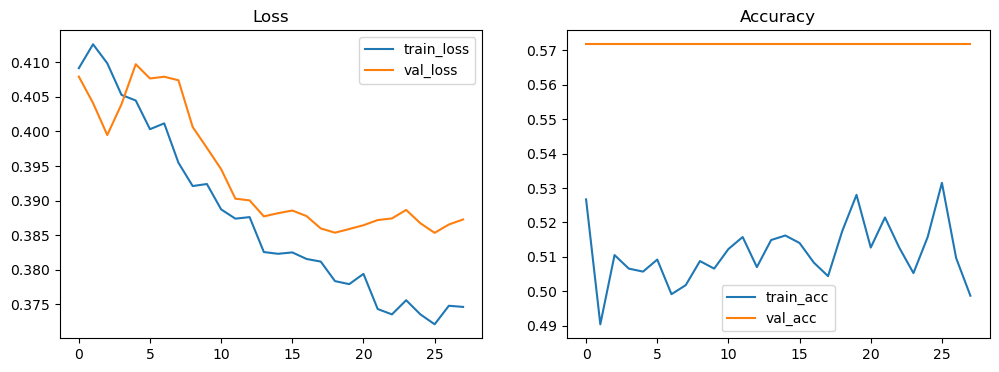

In [43]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

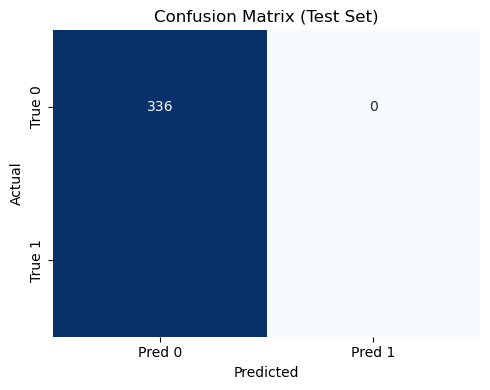

TN: 336, FP: 0, FN: 337, TP: 0
Precision: 0.0000, Recall: 0.0000, F1: 0.0000


In [44]:
# Confusion matrix on test set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_prob = model.predict(X_test_3d, verbose=0).ravel()
# Use default threshold 0.5 (or tune if needed)
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Optional: print supporting metrics
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
precision = tp / (tp + fp + 1e-7)
recall = tp / (tp + fn + 1e-7)
f1 = 2 * precision * recall / (precision + recall + 1e-7)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

In [45]:
# Detailed metrics: precision, recall, f1, support, and more
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc

# Use the predictions from previous cell if available; else compute
try:
    y_pred  # from previous cell
    y_prob  # from previous cell
except NameError:
    y_prob = model.predict(X_test_3d, verbose=0).ravel()
    threshold = 0.5
    y_pred = (y_prob >= threshold).astype(int)

# Core metrics
print("\nClassification Report (threshold=0.5):")
print(classification_report(y_test, y_pred, target_names=['No Continuation (0)','Uptrend Continues (1)'], digits=4))

prec, rec, f1, supp = precision_recall_fscore_support(y_test, y_pred, labels=[0,1], zero_division=0)
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print("Per-class metrics:")
print(f"  Class 0 - precision: {prec[0]:.4f}, recall: {rec[0]:.4f}, f1: {f1[0]:.4f}, support: {supp[0]}")
print(f"  Class 1 - precision: {prec[1]:.4f}, recall: {rec[1]:.4f}, f1: {f1[1]:.4f}, support: {supp[1]}")
print(f"Overall: accuracy: {acc:.4f}, balanced_accuracy: {bal_acc:.4f}")

# Probability-based metrics
try:
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC: {roc_auc:.4f}")
    pr_precision, pr_recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(pr_recall, pr_precision)
    print(f"PR AUC: {pr_auc:.4f}")
except Exception as e:
    print(f"Could not compute probability-based metrics: {e}")


Classification Report (threshold=0.5):
                       precision    recall  f1-score   support

  No Continuation (0)     0.4993    1.0000    0.6660       336
Uptrend Continues (1)     0.0000    0.0000    0.0000       337

             accuracy                         0.4993       673
            macro avg     0.2496    0.5000    0.3330       673
         weighted avg     0.2493    0.4993    0.3325       673

Per-class metrics:
  Class 0 - precision: 0.4993, recall: 1.0000, f1: 0.6660, support: 336
  Class 1 - precision: 0.0000, recall: 0.0000, f1: 0.0000, support: 337
Overall: accuracy: 0.4993, balanced_accuracy: 0.5000
ROC AUC: 0.5228
PR AUC: 0.5277


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
